# Dual Task Progress (DTP)
---
[2024.07/28] V1 created  

## Configurations
First, you need to configurate several options
- how are you raw datas? One csv per participants, or all together? See the different structures in ~/sample
- what do you want to save? One csv per participants, or all together? Do you also want the plot?
- what are the directions of your cognitive and motor tests? Does higher values means better or worst performance? In our synthetic exemple values, we considered 
    - "Cognitive" : Stroop test correct answers rate -> higher values = better performance
    - "Motor" : Timed Up-and-go test -> higher values = worst performance

In [36]:
# Set this to True if you have one CSV file for all subjects, or False if you have one CSV per subject
allTogether = True

# Set this to True if you want to save on report for all participants
saveAllTogether = True
# Set this to True if you want to save on report per participants
saveIndependent = True

# Set this to True if you want to save the final plot
savePlot = True

# Configuration for performance directionality of the evaluation tests
# True = higher values are better, False = lower values are better
performance_directionality = {
    "Cognitive": True,
    "Motor": False
}

# Needed libraries to import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Define the input path (~/sample)
path = os.path.join(os.getcwd(), 'sample')  # Path containing all .csv files
# Define the saving path (~/results)
results_path = os.path.join(os.getcwd(), 'results')
os.makedirs(results_path, exist_ok=True)


## Importing the data
We then import the data - one by one, or all together depending on the way `allTogether` was defined. We also check for any missing data, and print the correct import.

In [37]:


# Performance directionality dictionary
performance_directionality = {
    "Cognitive": True,  # Higher values are better for Cognitive performance
    "Motor": False  # Lower values are better for Motor performance
}

# Function to check for missing values in a DataFrame and print their locations
def check_missing_values(df, file_name):
    if df.isnull().values.any():
        print(f"Missing values found in {file_name}:")
        missing_values = df[df.isnull().any(axis=1)]
        for idx, row in missing_values.iterrows():
            missing_cols = row[row.isnull()].index.tolist()
            for col in missing_cols:
                print(f"  Missing value at ID: {row['ID']}, Column: {col}")
    else:
        print(f"No missing values in {file_name}")

# Function to load data from a single CSV file
def load_single_csv(file_path):
    df = pd.read_csv(file_path)
    check_missing_values(df, file_path)
    return df

# Function to load data from multiple CSV files in a directory
def load_multiple_csvs(path):
    csv_files = [file_name for file_name in os.listdir(path) if file_name.endswith('.csv')]
    data_dict = {}
    for file_name in csv_files:
        file_path = os.path.join(path, file_name)
        df = pd.read_csv(file_path).T  # Transpose the DataFrame
        df = df.reset_index(drop=False)
        new_cols = df.iloc[0].tolist()
        df = df.rename(columns=dict(zip(df.columns, new_cols)))
        df = df.drop(df.index[0])
        check_missing_values(df, file_name)
        data_dict[file_name] = df
    return data_dict

# Load data
if allTogether:
    # Load data from a single CSV file
    data_file = 'data.csv'
    data_file_path = os.path.join(path, data_file)
    if os.path.exists(data_file_path):
        df_all = load_single_csv(data_file_path)
        data_dict = {f"00{id}": df for id, df in df_all.groupby('ID')}
        print(f"1 .csv file imported from {data_file} - OK")
    else:
        print(f"{data_file} not found in the specified directory.")
else:
    # Load data from multiple CSV files
    csv_files = [file_name for file_name in os.listdir(path) if file_name.endswith('.csv')]
    data_dict = load_multiple_csvs(path)
    if len(csv_files) == len(data_dict):
        print(f"{len(csv_files)} .csv files imported - OK")
    else:
        print(f"Problem: {len(csv_files)} .csv files found but only {len(data_dict)} imported")


No missing values in /Users/mgg/Documents/GitHub/DualTaskEffectProgress/sample/data.csv
1 .csv file imported from data.csv - OK


In [38]:
# Displaying one subject, for the exemple
data_dict['001']


,ID,T1 - Single Task - Cognitive performance,T1 - Single Task - Motor performance,T1 - Dual Task - Cognitive performance,T1 - Dual Task - Motor performance,T2 - Single Task - Cognitive performance,T2 - Single Task - Motor performance,T2 - Dual Task - Cognitive performance,T2 - Dual Task - Motor performance
0,1,14.978987,15.448203,21.138984,17.903505,19.617521,15.685223,18.235758,7.207385


## Computing
It is now time for computation. Here, we :
- calculate the Dual Task Effect (DTE), using the formula
$$
\text{DTE} = \frac{\text{DT} - \text{ST}}{\text{ST}} \times 100
$$

- calculate the Dual Task Progress (DTP), using the formula  
$$
\text{DTP} = \text{DTE}_{T2} - \text{DTE}_{T1}
$$

- caracterise the DTE according to Plummer et al, 2013 ([DOI: 10.1155/2014/538602](https://onlinelibrary.wiley.com/doi/10.1155/2014/538602))  

![Figure Plummer et al. 2013](/Users/mgg/Documents/GitHub/DualTaskEffectProgress/images/DTE.jpg)


- caracterising the DTP according to Gallou-Guyot et al, 2024 ([DOI: ]())  


In [39]:
# Creating the functions, with automatic time points (T1, T2) and task (Cognitive, Motor) detection
# Dual Task Effect
def calculate_dual_task_effect(df, task_type, time_point):
    single_task_col = f"{time_point} - Single Task - {task_type} performance"
    dual_task_col = f"{time_point} - Dual Task - {task_type} performance"
    effect_col = f"{time_point} - {task_type} Dual Task Effect"
    better_higher = performance_directionality[task_type]
    
    if single_task_col in df.columns and dual_task_col in df.columns:
        if better_higher:
            df[effect_col] = (df[dual_task_col] - df[single_task_col]) / df[single_task_col] * 100
        else:
            df[effect_col] = (df[single_task_col] - df[dual_task_col]) / df[single_task_col] * 100
    else:
        print(f"Columns for {task_type} at {time_point} not found in the DataFrame")
    
    return df

# Dual Task Progress
def calculate_dual_task_progress(df, task_type):
    t1_effect_col = f"T1 - {task_type} Dual Task Effect"
    t2_effect_col = f"T2 - {task_type} Dual Task Effect"
    progress_col = f"{task_type} Dual Task Progress"
    
    if t1_effect_col in df.columns and t2_effect_col in df.columns:
        df[progress_col] = df[t2_effect_col] - df[t1_effect_col]
    else:
        print(f"Effect columns for {task_type} not found in the DataFrame")
    
    return df

# Determine the DTE category (initial and final)
def determine_effect_category(cognitive_effect, motor_effect):
    if cognitive_effect > 0 and motor_effect == 0:
        return 'Cognitive facilitation'
    elif cognitive_effect > 0 and motor_effect > 0:
        return 'Mutual facilitation'
    elif motor_effect > 0 and cognitive_effect == 0:
        return 'Motor facilitation'
    elif motor_effect > 0 and cognitive_effect < 0:
        return 'Motor priority trade off'
    elif motor_effect == 0 and cognitive_effect < 0:
        return 'Cognitive interference'
    elif motor_effect < 0 and cognitive_effect < 0:
        return 'Mutual interference'
    elif motor_effect < 0 and cognitive_effect == 0:
        return 'Motor interference'
    elif cognitive_effect > 0 and motor_effect < 0:
        return 'Cognitive priority tradeoff'
    elif cognitive_effect == 0 and motor_effect == 0:
        return 'No interference'
    return 'Unknown'

# Determine the DTP category
def determine_progress_category(cognitive_progress, motor_progress):
    if cognitive_progress < 0 and motor_progress == 0:
        return 'DTP -/0 : cognitive increase of CMI'
    elif cognitive_progress < 0 and motor_progress < 0:
        return 'DTP -/- : mutual increase of CMI'
    elif cognitive_progress == 0 and motor_progress < 0:
        return 'DTP 0/- : Motor increase of CMI'
    elif cognitive_progress > 0 and motor_progress < 0:
        return 'DTP +/- : motor trade-off of CMI'
    elif cognitive_progress > 0 and motor_progress == 0:
        return 'DTP +/0 : cognitive decrease of CMI'
    elif cognitive_progress > 0 and motor_progress > 0:
        return 'DTP +/+ : mutual decrease of CMI'
    elif cognitive_progress == 0 and motor_progress > 0:
        return 'DTP 0/+ : motor decrease of CMI'
    elif cognitive_progress < 0 and motor_progress > 0:
        return 'DTP -/+ : cognitive trade-off of CMI'
    elif cognitive_progress == 0 and motor_progress == 0:
        return 'DTP 0/0 : no progress'
    return 'Unknown'

# Apply the functions to each DataFrame in the dictionary
for key, df in data_dict.items():
    # DTE for Cognitive - percentage
    df = calculate_dual_task_effect(df, "Cognitive", "T1")
    df = calculate_dual_task_effect(df, "Cognitive", "T2")
    # DTE for Motor - percentage
    df = calculate_dual_task_effect(df, "Motor", "T1")
    df = calculate_dual_task_effect(df, "Motor", "T2")
    # DTP for cognitive and motor - percentage
    df = calculate_dual_task_progress(df, "Cognitive")
    df = calculate_dual_task_progress(df, "Motor")
    # Initial DTE - category
    df["Initial Dual Task Effect"] = df.apply(
        lambda row: determine_effect_category(row["T1 - Cognitive Dual Task Effect"], row["T1 - Motor Dual Task Effect"]),
        axis=1
    )
    # Final DTE - category
    df["Final Dual Task Effect"] = df.apply(
        lambda row: determine_effect_category(row["T2 - Cognitive Dual Task Effect"], row["T2 - Motor Dual Task Effect"]),
        axis=1
    )
    # DTP - category
    df["Dual Task Progress"] = df.apply(
        lambda row: determine_progress_category(row["Cognitive Dual Task Progress"], row["Motor Dual Task Progress"]),
        axis=1
    )
    
    data_dict[key] = df


## Saving and displaying the results
It is now time to save the results, as one document for all subjects or one per subjects depending on how `saveAllTogether` and `saveIndependent` are defined.

In [40]:
# Save independent files
if saveIndependent:
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    for key, value in data_dict.items():
        filename = os.path.join(results_path, f"{key}.csv")
        value.to_csv(filename, index=False)
    print(f"Saved {len(data_dict)} independent CSV files in {results_path}")

# Save concatenated file
if saveAllTogether:
    concatenated_df = pd.concat(data_dict.values(), axis=0)
    concatenated_df = concatenated_df.sort_values(by=['ID'])
    concatenated_filename = os.path.join(results_path, "concatenated_data.csv")
    concatenated_df.to_csv(concatenated_filename, index=False)
    print(f"Saved concatenated CSV file as {concatenated_filename}")


Saved 10 independent CSV files in /Users/mgg/Documents/GitHub/DualTaskEffectProgress/results
Saved concatenated CSV file as /Users/mgg/Documents/GitHub/DualTaskEffectProgress/results/concatenated_data.csv


In [41]:
# Displaying the general results (5 first subjects)
concatenated_df.head()


,ID,T1 - Single Task - Cognitive performance,T1 - Single Task - Motor performance,T1 - Dual Task - Cognitive performance,T1 - Dual Task - Motor performance,T2 - Single Task - Cognitive performance,T2 - Single Task - Motor performance,T2 - Dual Task - Cognitive performance,T2 - Dual Task - Motor performance,T1 - Cognitive Dual Task Effect,T2 - Cognitive Dual Task Effect,T1 - Motor Dual Task Effect,T2 - Motor Dual Task Effect,Cognitive Dual Task Progress,Motor Dual Task Progress,Initial Dual Task Effect,Final Dual Task Effect,Dual Task Progress
0,1,14.978987,15.448203,21.138984,17.903505,19.617521,15.685223,18.235758,7.207385,41.124259,-7.043513,-15.893771,54.049844,-48.167773,69.943615,Cognitive priority tradeoff,Motor priority trade off,DTP -/+ : cognitive trade-off of CMI
1,2,13.480289,19.578881,14.488541,14.752920,13.568198,10.356783,8.240412,23.931261,7.479452,-39.266718,24.648808,-131.068477,-46.746170,-155.717285,Mutual facilitation,Mutual interference,DTP -/- : mutual increase of CMI
2,3,15.442139,12.067792,11.146460,7.745180,11.308953,16.313472,19.275603,14.560526,-27.817900,70.445515,35.819406,10.745391,98.263415,-25.074015,Motor priority trade off,Mutual facilitation,DTP +/- : motor trade-off of CMI
3,4,11.903323,15.022998,7.755402,16.654646,11.465385,17.325409,10.003112,14.965519,-34.846753,-12.753802,-10.861003,13.620977,22.092951,24.481980,Mutual interference,Motor priority trade off,DTP +/+ : mutual decrease of CMI
4,5,10.402516,15.414289,15.576375,18.255695,11.856874,14.692083,13.349406,24.184498,49.736608,12.587903,-18.433580,-64.609048,-37.148705,-46.175468,Cognitive priority tradeoff,Cognitive priority tradeoff,DTP -/- : mutual increase of CMI


## Graphical representation
It's now time to represent every participants' DTP as a vector on the same plot, and to print the starting and stoping point according to Plummer et al., 2013. 

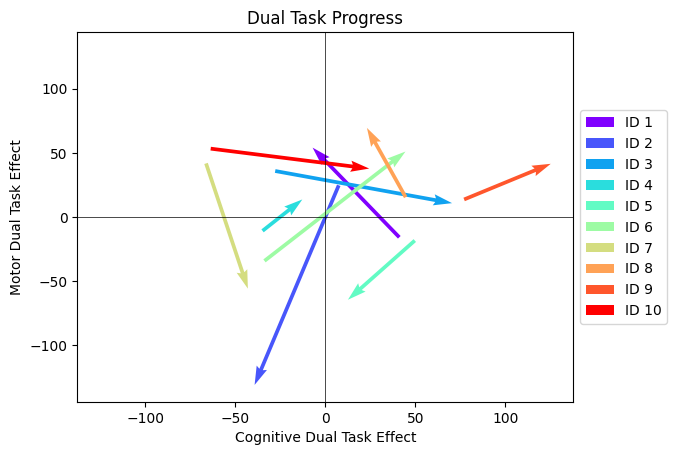

Participant 1    : went from Cognitive priority tradeoff    at T1, to Motor priority trade off       at T2 with a DTP -/+ : cognitive trade-off of CMI
Participant 2    : went from Mutual facilitation            at T1, to Mutual interference            at T2 with a DTP -/- : mutual increase of CMI
Participant 3    : went from Motor priority trade off       at T1, to Mutual facilitation            at T2 with a DTP +/- : motor trade-off of CMI
Participant 4    : went from Mutual interference            at T1, to Motor priority trade off       at T2 with a DTP +/+ : mutual decrease of CMI
Participant 5    : went from Cognitive priority tradeoff    at T1, to Cognitive priority tradeoff    at T2 with a DTP -/- : mutual increase of CMI
Participant 6    : went from Mutual interference            at T1, to Mutual facilitation            at T2 with a DTP +/+ : mutual decrease of CMI
Participant 7    : went from Motor priority trade off       at T1, to Mutual interference            at T2 with a 

In [42]:
# Generate a colormap with as many colors as there are unique IDs
num_colors = len(concatenated_df['ID'].unique())
colors = plt.cm.rainbow(np.linspace(0, 1, num_colors))

# Calculate the limits for x and y axes based on the data
x_min = concatenated_df[['T1 - Cognitive Dual Task Effect', 'T2 - Cognitive Dual Task Effect']].min().min()
x_max = concatenated_df[['T1 - Cognitive Dual Task Effect', 'T2 - Cognitive Dual Task Effect']].max().max()
y_min = concatenated_df[['T1 - Motor Dual Task Effect', 'T2 - Motor Dual Task Effect']].min().min()
y_max = concatenated_df[['T1 - Motor Dual Task Effect', 'T2 - Motor Dual Task Effect']].max().max()

# Define the limits for the plot
x_limit = max(abs(x_min), abs(x_max)) * 1.1  # Adding some padding
y_limit = max(abs(y_min), abs(y_max)) * 1.1  # Adding some padding

# Create the figure and axis
fig, ax = plt.subplots()

# Plot each participant's progress
for i, id_value in enumerate(concatenated_df['ID'].unique()):
    subset = concatenated_df[concatenated_df['ID'] == id_value]
    x_start = subset['T1 - Cognitive Dual Task Effect'].values[0]
    x_end = subset['T2 - Cognitive Dual Task Effect'].values[0]
    y_start = subset['T1 - Motor Dual Task Effect'].values[0]
    y_end = subset['T2 - Motor Dual Task Effect'].values[0]
    
    # Calculate the direction of the vector
    x_direction = x_end - x_start
    y_direction = y_end - y_start
    
    ax.quiver(x_start, y_start, x_direction, y_direction, angles='xy', scale_units='xy', scale=1, color=colors[i % len(colors)], label=f'ID {id_value}')

# Setting limits to center the plot around (0, 0)
ax.set_xlim(-x_limit, x_limit)
ax.set_ylim(-y_limit, y_limit)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Dual Task Progress')
ax.set_xlabel('Cognitive Dual Task Effect')
ax.set_ylabel('Motor Dual Task Effect')

plt.show()

# Print information for each participant
for i, id_value in enumerate(concatenated_df['ID'].unique()):
    subset = concatenated_df[concatenated_df['ID'] == id_value].iloc[0]
    initial_effect = subset['Initial Dual Task Effect']
    final_effect = subset['Final Dual Task Effect']
    progress = subset['Dual Task Progress']
    print(f"Participant {id_value:<5}: went from {initial_effect:<30} at T1, to {final_effect:<30} at T2 with a {progress}")


## Saving the plot

In [43]:
# Save or show the plot
if savePlot:
    results_path = os.path.join(os.getcwd(), 'results')
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    plot_filename = os.path.join(results_path, 'DTP_plot.jpg')
    fig.savefig(plot_filename, format='jpg', bbox_inches='tight')
    print(f'{plot_filename} saved')
else:
    pass


/Users/mgg/Documents/GitHub/DualTaskEffectProgress/results/DTP_plot.jpg saved
